# Delete 102 observed streamflow

In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu
import shapefile #the pyshp module
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT,pst_config

sys.path.insert(0, 'D:/spark-brc_gits/apexmf_git/apexmf_pkgs')
import apexmf_pst_utils

flopy is installed in C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\flopy


# <span style="color:blue">1. Set up pilot points network for the white model some</span>.

There are multiple approaches to implementing pilot points with PEST++.  

In this class, we will use some kick-ass pyemu sweetness

### 1.1. Set up zones for where pilot points will be interpolated

We can have pilot point networks in multiple zones. In this case, we will make a simple zone file using `IBOUND` such that all active cells are in the same interpolation zone.

In [2]:
working_dir = 'D:/Projects/Watersheds/White/Analysis/APEX-MODFLOWs/calibration/v03/'
mname = "wt_1500.nam"
os.chdir(working_dir)




In [3]:
# m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=wd,load_only=[]) #<-- load only prevents reading ibound
m = flopy.modflow.Modflow.load(
            mname,
            model_ws=working_dir
            )
m.check()

OSError: cannot find name file: D:/Projects/Watersheds/White/Analysis/APEX-MODFLOWs/calibration/v03/wt_1500.nam

<AxesSubplot:title={'center':'ibound_layer_0'}>

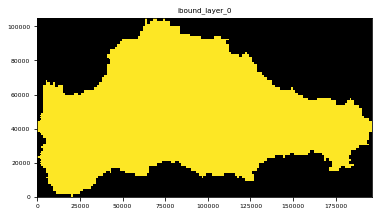

In [7]:
m.bas6.ibound[0].plot()

# Check first version all setups for pilot points / version2 has same pilot points

In [4]:
mf_obs = pd.read_csv(
                    "MODFLOW/modflow.obs",
                    delim_whitespace=True,
                    skiprows = 2,
                    usecols = [3, 4],
                    index_col = 0,
                    names = ["grid_id", "mf_elev"],)
grid_ids = mf_obs.index.tolist()

In [5]:
grid_ids

[4912, 5959]

In [6]:
os.chdir(working_dir)

In [7]:
os.getcwd()

'D:\\Projects\\Watersheds\\White\\Analysis\\APEX-MODFLOWs\\calibration\\v03'

# Build instruction files (Streamflow / Watertable)

### 1. Streamflow (output.rch)

# 1.2. Build instruction files (streamflow / watertable / baseflow)
## 1.2.1. Streamflow (output.rch)

In [8]:
# file path
rch_file = 'SITE66.RCH'
# reach numbers that are used for calibration
subs = [66, 133]
# extract month_streamflow
apexmf_pst_utils.extract_month_str(rch_file, subs, '1/1/1985', '1/1/2000', '12/31/2019')

stf_066.txt file has been created...
stf_133.txt file has been created...
Finished ...


### 1.2.3. Create instruction files for each str_sim file using the 'streamflow.obd' file

In [9]:
# because we have 3 streamgages let's loop for them
# read streamobd and get column names
stf_obd = pd.read_csv(
                    'stf_mon.obd',
                    sep='\t',
                    index_col=0,
                    parse_dates=True,
                    na_values=[-999, '']
                    )
# stf_obd_c = stf_obd.resample('M').mean()
# stf_obd_c.to_csv('streamflow_m.obd', sep='\t', na_rep=-999, float_format='%.2f')
obds = stf_obd.columns.tolist()
obds.remove('sub046')
obds.remove('sub130')
obds.remove('sub102')
print(obds)
sim_files = ['stf_{:03d}.txt'.format(x) for x in subs]
# sed_files = ['sed_{:03d}.txt'.format(x) for x in subs]
# sim_files = sim_files + sed_files
print(sim_files)

['sub066', 'sub133']
['stf_066.txt', 'stf_133.txt']


In [10]:
# create instruction files for each sim file
for i in range(len(sim_files)):
    apexmf_pst_utils.stf_obd_to_ins(sim_files[i], obds[i], '1/1/2000', '12/31/2019', time_step='month')

stf_066.txt.ins file has been created...
stf_133.txt.ins file has been created...


In [11]:
# We do have watertable data now
grid_ids = [4912, 5959]
apexmf_pst_utils.extract_depth_to_water(grid_ids, '1/1/1985', '12/31/2019')

dtw_4912.txt file has been created...
dtw_5959.txt file has been created...
Finished ...


In [12]:
apexmf_pst_utils.mf_obd_to_ins('dtw_5959.txt', 'g593', '1/1/1985', '12/31/2019')

dtw_5959.txt.ins file has been created...


In [9]:
io_files = pyemu.helpers.parse_dir_for_io_files('.')
pst = pyemu.Pst.from_io_files(*io_files)
pyemu.helpers.pst_from_io_files(io_files[0], io_files[1], io_files[2], io_files[3], 'white_dummy.pst')

# print(os.chdir(".."))
io_files

C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file dtw_4912.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))
C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file dtw_5959.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))
C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file stf_066.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file dtw_4912.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file dtw_5959.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file stf_066.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.


C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\pyemu\pst\pst_utils.py:615: UserWarning: error processing instruction file stf_133.txt.ins, trying inschek: substring not found
  warnings.warn("error processing instruction file {0}, trying inschek: {1}".format(ins_file,str(e)))


error using inschek for instruction file stf_133.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file dtw_4912.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file dtw_5959.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file stf_066.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file stf_133.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
noptmax:30, npar_adj:123, nnz_obs:6810


(['hk0pp.dat.tpl', 'mf_riv.par.tpl', 'PARM1501.DAT.tpl', 'sy0pp.dat.tpl'],
 ['hk0pp.dat', 'mf_riv.par', 'PARM1501.DAT', 'sy0pp.dat'],
 ['dtw_4912.txt.ins',
  'dtw_5959.txt.ins',
  'stf_066.txt.ins',
  'stf_133.txt.ins'],
 ['dtw_4912.txt', 'dtw_5959.txt', 'stf_066.txt', 'stf_133.txt'])

The ``parse_dir_for_io_files()`` helper is looking for files with the ".tpl" and ".ins" extension.  This assumes that the corresponding model input and model output files are the same name, minus the ".tpl" and ".ins" extension, respectively.  These file lists are then passed to another helper, which builds a basic control file for you (``Pst.from_io_files()``).  Let's look at this generic ``Pst`` instance:

In [10]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hk000,hk000,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk001,hk001,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk002,hk002,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk003,hk003,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk004,hk004,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sy046,sy046,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sy047,sy047,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sy048,sy048,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


## 2.1. Change parameter group name

In [11]:
for i in range(len(par)):
    if (par.iloc[i, 0][:2]) == 'sy':
        par.iloc[i, 6] = 'sy'
    elif par.iloc[i, 0][:7] == 'rivbot_':
        par.iloc[i, 6] = 'rivbot'
    elif par.iloc[i, 0][:6] == 'rivcd_':
        par.iloc[i, 6] = 'rivcd'
    elif par.iloc[i, 0][:2] == 'hk':
        par.iloc[i, 6] = 'hk'
    elif par.iloc[i, 0][:1] == 'p':
        par.iloc[i, 6] = 'apex'
    # else:
    #     par.iloc[i, 6] = 'str'
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hk000,hk000,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
hk001,hk001,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
hk002,hk002,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
hk003,hk003,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
hk004,hk004,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy046,sy046,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy047,sy047,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy048,sy048,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1


In [12]:
par = par.sort_values(by=['pargp', 'parnme'])
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
p12,p12,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p15,p15,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p16,p16,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p17,p17,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p20,p20,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy046,sy046,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy047,sy047,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy048,sy048,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1


### 3. Set par ranges and values for MODFLOW

In [13]:
# for MODFLOW parameters
for i in range(len(par)):
    if (par.iloc[i, 6]) == 'hk':
        par.iloc[i, 4] = 1.000000e-03
        par.iloc[i, 5] = 1.000000e+03
    elif par.iloc[i, 6] == 'sy':
        par.iloc[i, 3] = 0.100000e+00 
        par.iloc[i, 4] = 1.000000e-03
        par.iloc[i, 5] = 0.700000e+00        
    elif par.iloc[i, 6] == 'rivcd':
        par.iloc[i, 3] = 50.01   # initial    
        par.iloc[i, 4] = 0.1   # lower
        par.iloc[i, 5] = 100   # upper
        par.iloc[i, 8] = -50   # offset
    elif par.iloc[i, 6] == 'rivbot':
        par.iloc[i, 3] = 5.0001   # initial    
        par.iloc[i, 4] = 0.1   # lower
        par.iloc[i, 5] = 10   # upper
        par.iloc[i, 8] = -5   # offset
#     else:
#         par.iloc[i, 6] = 'str_par'


In [14]:
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
p12,p12,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p15,p15,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p16,p16,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p17,p17,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p20,p20,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,0.1,1.000000e-03,7.000000e-01,sy,1.0,0.0,1
sy046,sy046,log,factor,0.1,1.000000e-03,7.000000e-01,sy,1.0,0.0,1
sy047,sy047,log,factor,0.1,1.000000e-03,7.000000e-01,sy,1.0,0.0,1
sy048,sy048,log,factor,0.1,1.000000e-03,7.000000e-01,sy,1.0,0.0,1


# Update parameters

In [15]:
pst.parameter_data = apexmf_pst_utils.export_pardb_pest(par)
par = pst.parameter_data
pst.parameter_data = apexmf_pst_utils.update_hk_pars(par)
par = pst.parameter_data
pst.parameter_data = apexmf_pst_utils.update_sy_pars(par)
par = pst.parameter_data


In [16]:
# par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
p12,p12,log,factor,2.500000,1.50000,2.5,apex,1.0,0.0,1
p15,p15,log,factor,0.000010,0.00001,0.3,apex,1.0,0.0,1
p16,p16,log,factor,1.378300,1.00000,1.5,apex,1.0,0.0,1
p17,p17,log,factor,0.500000,0.00001,0.5,apex,1.0,0.0,1
p20,p20,log,factor,0.299280,0.05000,0.4,apex,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,0.112634,0.00100,0.7,sy,1.0,0.0,1
sy046,sy046,log,factor,0.249720,0.00100,0.7,sy,1.0,0.0,1
sy047,sy047,log,factor,0.138179,0.00100,0.7,sy,1.0,0.0,1
sy048,sy048,log,factor,0.138774,0.00100,0.7,sy,1.0,0.0,1



Cool - the other tpl files were found and parsed - parameter listed in them were added to the control file.  But we have generic entries for initial values bounds...

## Observation

In [28]:
obd = pst.observation_data
print(obd)

                      obsnme        obsval  weight  obgnme
g492_20100622  g492_20100622  1.000000e+10     1.0    g492
g492_20100623  g492_20100623  1.000000e+10     1.0    g492
g492_20100624  g492_20100624  1.000000e+10     1.0    g492
g492_20100625  g492_20100625  1.000000e+10     1.0    g492
g492_20100626  g492_20100626  1.000000e+10     1.0    g492
...                      ...           ...     ...     ...
sub133_201908  sub133_201908  1.000000e+10     1.0  sub133
sub133_201909  sub133_201909  1.000000e+10     1.0  sub133
sub133_201910  sub133_201910  1.000000e+10     1.0  sub133
sub133_201911  sub133_201911  1.000000e+10     1.0  sub133
sub133_201912  sub133_201912  1.000000e+10     1.0  sub133

[6810 rows x 4 columns]


In [29]:
for i in range(len(obd)):
    if obd.iloc[i, 0][:6] == 'sub066':
        obd.iloc[i, 3] = 'sub066'
    elif obd.iloc[i, 0][:6] == 'sub133':
        obd.iloc[i, 3] = 'sub133'
    elif obd.iloc[i, 0][:6] == 'sub102':
        obd.iloc[i, 3] = 'sub102'
    elif obd.iloc[i, 0][:4] == 'g492':
        obd.iloc[i, 3] = 'g492'
    elif obd.iloc[i, 0][:4] == 'g593':
        obd.iloc[i, 3] = 'g593'


In [30]:
print(obd)

                      obsnme        obsval  weight  obgnme
g492_20100622  g492_20100622  1.000000e+10     1.0    g492
g492_20100623  g492_20100623  1.000000e+10     1.0    g492
g492_20100624  g492_20100624  1.000000e+10     1.0    g492
g492_20100625  g492_20100625  1.000000e+10     1.0    g492
g492_20100626  g492_20100626  1.000000e+10     1.0    g492
...                      ...           ...     ...     ...
sub133_201908  sub133_201908  1.000000e+10     1.0  sub133
sub133_201909  sub133_201909  1.000000e+10     1.0  sub133
sub133_201910  sub133_201910  1.000000e+10     1.0  sub133
sub133_201911  sub133_201911  1.000000e+10     1.0  sub133
sub133_201912  sub133_201912  1.000000e+10     1.0  sub133

[6810 rows x 4 columns]


## 2.3. Import measured data

In [31]:
gwt_obd = pd.read_csv('MODFLOW/dtw_day.obd',
                        sep='\t',
                        index_col = 0,
                        parse_dates = True,
                        na_values=[-999, '']
                        )
gwt_obd = gwt_obd['6/22/2010': '12/31/2019']
gwt_obd = gwt_obd[['g593', 'g492']]
gwt_obd

,g593,g492
date,,
2010-06-22,-18.60,-85.51
2010-06-23,-18.62,-85.53
2010-06-24,-18.60,-85.53
2010-06-25,-18.59,-85.53
2010-06-26,-18.59,-85.53
...,...,...
2019-12-27,-17.59,NaN
2019-12-28,-17.60,NaN
2019-12-29,-17.63,NaN


In [32]:
stf_obd = pd.read_csv('stf_mon.obd',
                       sep='\t',
                       index_col = 0,
                       parse_dates = True,
                       na_values=[-999, '']
                     )
stf_obd = stf_obd['1/1/2000': '12/31/2019']
stf_obd = stf_obd.drop(['sub046', 'sub102', 'sub130'], axis=1)
stf_obd

,sub066,sub133
date,,
2000-01-31,12.92,10.30
2000-02-29,11.84,9.82
2000-03-31,12.32,9.88
2000-04-30,18.29,18.17
2000-05-31,43.94,44.65
...,...,...
2019-08-31,11.58,9.71
2019-09-30,9.09,5.82
2019-10-31,11.43,9.36


In [33]:
# Get sub list based on obd order
sub_order = []
for i in obd.obgnme.tolist():
    if i not in sub_order:
        sub_order.append(i)
sub_order


['g492', 'g593', 'sub066', 'sub133']

In [34]:
# get total list from each sub obd, delete na vals
tot_obd = []
for i in sub_order[:2]:
    tot_obd += gwt_obd[i].dropna().tolist()
for j in sub_order[2:]:
    tot_obd += stf_obd[j].dropna().tolist()    
len(tot_obd)
# tot_obd

6810

In [35]:
obd.loc[:, 'obsval'] = tot_obd
obd

,obsnme,obsval,weight,obgnme
g492_20100622,g492_20100622,-85.51,1.0,g492
g492_20100623,g492_20100623,-85.53,1.0,g492
g492_20100624,g492_20100624,-85.53,1.0,g492
g492_20100625,g492_20100625,-85.53,1.0,g492
g492_20100626,g492_20100626,-85.53,1.0,g492
...,...,...,...,...
sub133_201908,sub133_201908,9.71,1.0,sub133
sub133_201909,sub133_201909,5.82,1.0,sub133
sub133_201910,sub133_201910,9.36,1.0,sub133
sub133_201911,sub133_201911,9.39,1.0,sub133


In [36]:
pst.observation_data =obd

In [37]:
obd

,obsnme,obsval,weight,obgnme
g492_20100622,g492_20100622,-85.51,1.0,g492
g492_20100623,g492_20100623,-85.53,1.0,g492
g492_20100624,g492_20100624,-85.53,1.0,g492
g492_20100625,g492_20100625,-85.53,1.0,g492
g492_20100626,g492_20100626,-85.53,1.0,g492
...,...,...,...,...
sub133_201908,sub133_201908,9.71,1.0,sub133
sub133_201909,sub133_201909,5.82,1.0,sub133
sub133_201910,sub133_201910,9.36,1.0,sub133
sub133_201911,sub133_201911,9.39,1.0,sub133


### 4. Export control file

In [38]:
pst.control_data.noptmax=0
pst.model_command = 'python forward_run.py'
pst.write('white_pest.pst')

noptmax:0, npar_adj:123, nnz_obs:6810


also cool - the instruction files in the directory were also found and parsed so that observation listed in the instruction files were added as well. There are some subtlies here, but we will skip them for now.

## Regularization

Regularization is ....

in pyemu, we can add two forms of regularization:
- preferred value: we want the parameter values to stay as close to the initial values as possible
- preferred difference: we prefer the differences in parameter values to be minimized

Preferred value is easy to understand, we simply add ``prior_information`` to the control file to enforce this condition.  pyemu uses a helper for this:

In [36]:
# load the pre-constructed pst
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [37]:
pyemu.helpers.zero_order_tikhonov(pst,parbounds=False)

In [38]:
pst.prior_information

,pilbl,equation,obgnme,weight
0,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,1.0
1,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,1.0
2,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,1.0
3,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,1.0
4,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,1.0
5,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,1.0
6,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,1.0
7,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,1.0
8,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,1.0
9,hk09,1.0 * log(hk09) = 6.989700E-01,regulhk,1.0


Ok, that's fine, but should the weight on preferring HK not to change be the same as preferring recharge not to change?  Seems like we would want recharge to change less than HK.  This preference can be expressed by using the parameter bounds to form the weights

In [43]:
pyemu.helpers.zero_order_tikhonov(pst,parbounds=True)

In [44]:
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
hk00,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,0.500000
hk01,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,0.500000
hk02,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,0.500000
hk03,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,0.500000
hk04,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,0.500000
hk05,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,0.500000
hk06,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,0.500000
hk07,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,0.500000
hk08,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,0.500000


Now we are really preferring recharge not to change...good!

So what about preferred difference regularization?  Well pyemu can do that too.  Remember that ``Cov``ariance matrix we built above? It expresses the spatial relationship between pilot points, so we use to setup these prior information equations:

In [45]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix


Exception: Matrix.indices(): name not found: porosity

In [46]:
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
hk00,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,0.500000
hk01,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,0.500000
hk02,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,0.500000
hk03,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,0.500000
hk04,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,0.500000
hk05,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,0.500000
hk06,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,0.500000
hk07,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,0.500000
hk08,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,0.500000


What happened?  We replace the preferred value equations with a bunch of new equations.  These equations each include two parameter names and have different weights - can you guess what the weights are?  The weights are the pearson correlation coefficients (CC) between the pilot points (remember those from way back?).  These CC values are calculated from the covariance matrix, which is implied by the geostatistical structure...whew! 

# For river Bed conductance interpolation

In [62]:
# interpolate the pilot point values to the grid
riv_cond = pyemu.gw_utils.fac2real(ppf,factors_file=ppf+".fac",out_file=None)

In [64]:
np.shape(riv_cond)

(154, 268)

## 1. get only river grids

In [139]:
df_riv = pd.read_csv(
                    shpwd + "\\mf\\ss_072519.riv",
                    delim_whitespace=True,
                    skiprows=3,
#                     usecols=[1,2],
                    header=None
                    )

In [136]:
new_riv_cf = [riv_cond[df_riv.iloc[i, 0], df_riv.iloc[i, 1]] for i in range(len(df_riv))]

In [137]:
df_riv.iloc[:, 4] = new_riv_cf
df_riv.iloc[:, 4] = df_riv.iloc[:, 4].map(lambda x: '{:.10e}'.format(x))
df_riv.iloc[:, 3] = df_riv.iloc[:, 3].map(lambda x: '{:.10e}'.format(x))
df_riv.iloc[:, 5] = df_riv.iloc[:, 5].map(lambda x: '{:.10e}'.format(x))

In [138]:
with open(os.path.join(shpwd + "\\mf", "ss_072519.riv"), 'w') as f:
    f.write("# RIV: River package file created on 7/25/2019 by ModelMuse version 4.0.0.0." + "\n")
    f.write("  1467     9 AUXILIARY IFACE # DataSet 2: MXACTC IRIVCB Option" + "\n")
    f.write("  1467     0 # Data Set 5: ITMP NP Stress period 1" + "\n")    
    df_riv.to_csv(f, sep='\t',
                  header=False,
                  index=False,
#                   float_format='%.2f', 
                  line_terminator='\n', 
                  encoding='utf-8')


# Build instruction files (Streamflow / Watertable)

### 1. Streamflow (channel_day.txt)

In [68]:
import csv

wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_middle_bosque"
df_str = pd.read_csv(
                    wd2 + "\\channel_day - Copy.txt",
                    delim_whitespace=True,
                    skiprows=3,
#                     usecols=[1,2],
                    header=None
                    )
test = []
for i in range(len(df_str)):
    if df_str.iloc[i, 6] == 'cha53':
        a = 'l1 w w w w w w w w w '
        b = '!str_{}{:02d}{:02d}!'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])
        test.append(a+b)
    else:
        a = 'l1'
        test.append(a)


with open('str.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")  
    writer = csv.writer(f)
    for row in test:
        writer.writerow([row])


### 2. Watertable (modflow_cell_obs.txt)

In [49]:
import csv
import pandas as pd
import numpy as np

st_date = '1/1/1980'
wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_middle_bosque"
df_wt = pd.read_csv(
                    wd2 + "\\modflow_cell_obs.txt",
                    delim_whitespace=True,
                    skiprows=1,
#                     usecols=[1,2],
                    header=None
                    )
df_wt.index = pd.date_range(st_date, periods=len(df_wt))
# print(df_str)

co1L = []
co2D = []



# for i in range(len(df_str)):
#     if ((df_wt.index[i].strftime('%Y%m%d') >= '19850821') & (df_wt.index[i].strftime('%Y%m%d') <= '19860507')):
#         print('true')
df_wt['date'] = df_wt.index.strftime('%Y%m%d')
# df_wt['test'] = CO1L['8/21/1985':'5/7/1986']
# df_wt['test'] = df_wt[(df_wt.index >= '08/21/1985') & (df_wt.index <= '05/07/1986')] = 'w'
df_wt['2nd'] = np.where((df_wt.index >= '08/21/1985') & (df_wt.index <= '05/07/1986'), ('l1 !wt_2nd'+df_wt['date']+'!'), 'l1 w')
df_wt['1st'] = np.where((df_wt.index >= '09/30/1985') & (df_wt.index <= '04/01/1986'), ('!wt_1nd'+df_wt['date']+'!'), ' w')


print(df_wt)

with open('wt.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")
    df_wt.to_csv(f, sep='\t',
                  header=False,
                  index=False,
#                   float_format='%.2f', 
                  line_terminator='\n', 
                  columns=('2nd','1st'),
                  encoding='utf-8')

'''
test = []
for i in range(len(df_str)):
    if df_str.iloc[i, 6] == 'cha53':
        a = 'l1 w w w w w w w w '
        b = '!str_{}{:02d}{:02d}!'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])
        test.append(a+b)
    else:
        a = 'l1'
        test.append(a)


with open('str.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")  
    writer = csv.writer(f)
    for row in test:
        writer.writerow([row])
'''

                   0         1      date   2nd 1st
1980-01-01  255.5776  253.4422  19800101  l1 w   w
1980-01-02  255.6870  253.5240  19800102  l1 w   w
1980-01-03  255.7828  253.5971  19800103  l1 w   w
1980-01-04  255.8695  253.6645  19800104  l1 w   w
1980-01-05  255.9489  253.7285  19800105  l1 w   w
...              ...       ...       ...   ...  ..
2005-12-27  263.4627  261.2057  20051227  l1 w   w
2005-12-28  263.4421  261.1927  20051228  l1 w   w
2005-12-29  263.4519  261.1992  20051229  l1 w   w
2005-12-30  263.4284  261.1831  20051230  l1 w   w
2005-12-31  263.4290  261.1830  20051231  l1 w   w

[9497 rows x 5 columns]


'\ntest = []\nfor i in range(len(df_str)):\n    if df_str.iloc[i, 6] == \'cha53\':\n        a = \'l1 w w w w w w w w \'\n        b = \'!str_{}{:02d}{:02d}!\'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])\n        test.append(a+b)\n    else:\n        a = \'l1\'\n        test.append(a)\n\n\nwith open(\'str.ins\', "w", newline=\'\') as f:\n    f.write("pif ~" + "\n")  \n    writer = csv.writer(f)\n    for row in test:\n        writer.writerow([row])\n'

In [148]:
a = np.full((33, 55), 10)

In [149]:
np.shape(a)

(33, 55)

In [155]:
np.savetxt('test.txtt', a, fmt='%.12e', delimiter='\t')
np.savetxt('vtest.txtt', a/10, fmt='%.12e', delimiter='\t')

In [154]:
b = np.loadtxt('test.txtt')
b/10

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [111]:
with open('hk04.dat', 'r') as f:
    data = [x.strip().split() for x in f if x.strip()]
hk = float(data[0][4])
hk

1.0

In [120]:
data_fac = ['hk01.dat', 'hk02.dat', 'hk03.dat', 'sy01.dat', 'sy02.dat', 'sy03.dat']
for i in data_fac:
    if i[:2] == 'hk':
        print('true')



true
true
true


In [118]:
print(a)

hk01.dat.ref


In [119]:
b/10

TypeError: unsupported operand type(s) for /: 'str' and 'int'